# Benchmarks

This notebook will calculate benchmarks/baselines used in the thesis.

The following benchmarks are implemented in this notebook:

1. Simple heuristics
    - Predict the previous value
    - Predict the mean of the training data
    - Predict the moving average of the sequence
2. Linear regression
    - Linear regression using least squares minimisation
    - Ridge regression
    - LASSO
    - Elastic Nets (ElNet)
3. Simpler Machine Learning
    - Random Forest (RF)
    - Gradient Boosting Machines (GBM)

In [71]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

from functions import MAE, RMSE, split_dataset

# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

## Loading the data

In [72]:
def read_files(path, method):
    if method=="scaled":
        train = np.load("{0}data_scaled_train.npy".format(path))
        valid = np.load("{0}data_scaled_valid.npy".format(path))
        test = np.load("{0}data_scaled_test.npy".format(path))
    else:
        train = np.load("{0}train_{1}.npy".format(path,method))
        valid = np.load("{0}valid_{1}.npy".format(path,method))
        test = np.load("{0}test_{1}.npy".format(path,method))
        
    return train, valid, test

def read_metadata():
    path = ROOT_PATH + "data/metadata/"
    
    stats = pd.read_csv(path + "stats.csv", sep=",")
    
    # tags
    target_tags = pd.read_csv(path + "tags/target_tags.csv", sep=";")["Name"].values
    feature_tags = stats["Tag"].values
    boruta_tags = pd.read_csv(path + "tags/selected_tags_boruta.csv", sep=",")["Tag"].values
    
    # timestamps
    ts = np.load(path + "timestamps/dtimestamps.npy")
    ts_train = np.load(path + "timestamps/ts_train.npy")
    ts_valid = np.load(path + "timestamps/ts_valid.npy")
    ts_test = np.load(path + "timestamps/ts_test.npy")
    
    return target_tags, feature_tags, boruta_tags, stats, ts, ts_train, ts_valid, ts_test

In [73]:
scaled_train, scaled_valid, scaled_test = read_files(ROOT_PATH + "data/scaled/", "scaled")
pca_train, pca_valid, pca_test = read_files(ROOT_PATH+"data/feature_selection/pca/", "pca")
bor_train, bor_valid, bor_test = read_files(ROOT_PATH+"data/feature_selection/boruta/", "bor")
target_tags, feature_tags, boruta_tags, stats, ts, ts_train, ts_valid, ts_test = read_metadata()

In [74]:
print(scaled_train.shape, pca_train.shape, bor_train.shape)
assert np.all(scaled_train[:,:3] == pca_train[:,:3])
assert np.all(scaled_test[:,:3] == bor_test[:,:3])

(53211, 98) (53211, 25) (53211, 38)


## Global functions for evaluation

In [147]:
def evaluate_error(preds, targets, target_stdevs=stats.loc[:len(target_tags)-1,"Std"].values):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    
    maes = MAE(targets, preds, vector=True)
    maes_unstd = (maes * target_stdevs)
    avg_mae = np.mean(maes)
    avg_mae_unstd = np.mean(maes_unstd)

    err_df = pd.DataFrame(np.column_stack([target_tags, maes, maes_unstd]), 
                          columns=['Tag', 'MAE (Standardized)', 'MAE (Unstandardized)'])
    err_df.loc[len(err_df)] = ["Average", avg_mae, avg_mae_unstd]
    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'err_df': err_df,
        'err_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
        'avg_mae': avg_mae,
        'avg_mae_unstd': avg_mae_unstd
    }
    
    return return_dict

In [148]:
def get_summary(val_dicts, test_dicts, columns, indexes, unstd=False, texpath=None, round_digits=4):
    """
    Method that concatenates validation and test dictionaries (as obtained by evaluate_error()) into a dataframe.
    Is typically used to get a summary of multiple methods and their performance on test and validation data. 
    
    :param val_dicts: Validation dictionaries as obtained by evalueate_error()
    :param test_dicts: Test dictionaries as obtained by evaluate_error()
    :param columns: Vector of column names for the dataframe
    :param indexes: Vector of index names for the dataframe
    :param unstd: Boolean if the MAEs should be unstandardized or not. Default=False. 
    :param texpath: Path to save the obtained latex output. Default=None. 
    :round_digit: The significant digits to round a decimal to, used in format_digit(). Default=4. 
    
    :return: The summary dataframe and the latex string of the dataframe. 
    """
    
    name = 'maes_unstd' if unstd else 'maes'
    val_data = []
    for i, d in enumerate(val_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        val_data.append(tmp)

    test_data = []
    for i, d in enumerate(test_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        test_data.append(tmp)

    val_df = pd.DataFrame(np.vstack(val_data), index = indexes, columns=columns)
    test_df = pd.DataFrame(np.vstack(test_data), index = indexes, columns=columns)
    summary_df = pd.concat([val_df, test_df], axis=1, keys=["Validation", "Test"])
    
    tex = latexify(summary_df)

    if texpath is not None: # save the file
        with open(texpath, 'w+') as f:
            f.write(tex)
    
    return summary_df, tex

# Simple heuristics
---

In [149]:
x_train, y_train = split_dataset(scaled_train)
x_valid, y_valid = split_dataset(scaled_valid)
x_test, y_test = split_dataset(scaled_test)

In [150]:
def evaluate_heuristic(func, y_valid, y_test):
    """
    Evaluates a heuristic by printing results for the validation and testing data.
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :return val_errs, test_errs: The dictionaries obtained by the evaluate_error()-function. 
    """
    
    print("\n       Validation data")
    preds, targets = func(y_valid)
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds, targets = func(y_test)
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [151]:
def visualise_heuristic(func, y_data=y_valid, n_obs=100, signal=1):
    """
    Visualises the heuristic with a sample plot. 
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :param y_data: The data with the true targets. Default set to y_valid. 
    :param n_obs: The number of observations that will be plotted. Default set to 100. 
    :param signal: The target that will be plotted. Default set to 1, i.e. the temperature. 
    """
    
    preds, targets = func(y_data)
    preds = preds[:,signal] if np.array(preds).shape==targets.shape else np.repeat(preds[signal],len(y_data))
    targets = targets[:,signal]

    plt.figure()
    plt.plot(preds[:n_obs], linestyle="dashed", lw=2, c="darkblue", label="Predicted")
    plt.plot(targets[:n_obs], c="darkred", lw=2, label="True")
    plt.legend(frameon=True)
    plt.ylabel(target_tags[signal])
    plt.show()

### Predict previous 
Now setting $y(t+1) = y(t)$. Visualising this with a plot:

In [152]:
def predict_previous(target_data):
    preds = target_data[:-1,:]
    targets = target_data[1:,:]
    
    return preds, targets

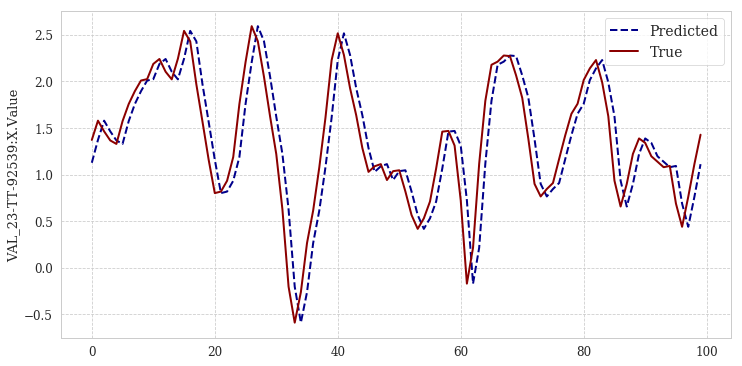

In [153]:
visualise_heuristic(predict_previous)

In [154]:
print("\nPREDICTING PREVIOUS")
val_prev, test_prev = evaluate_heuristic(predict_previous,y_valid,y_test)


PREDICTING PREVIOUS

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.90733 |             3063.82727 |
|  1 | VAL_23-TT-92539:X.Value    |              0.22118 |                0.21586 |
|  2 | VAL_23-PT-92539:X.Value    |              0.55857 |                0.13824 |
|  3 | Average                    |              0.56236 |             1021.39379 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL

### Predict the mean value of training data

In [155]:
target_means_stdized = np.mean(y_train, axis=0)
def predict_mean(y_data):   
    preds = target_means_stdized
    targets = y_data
    return preds, targets

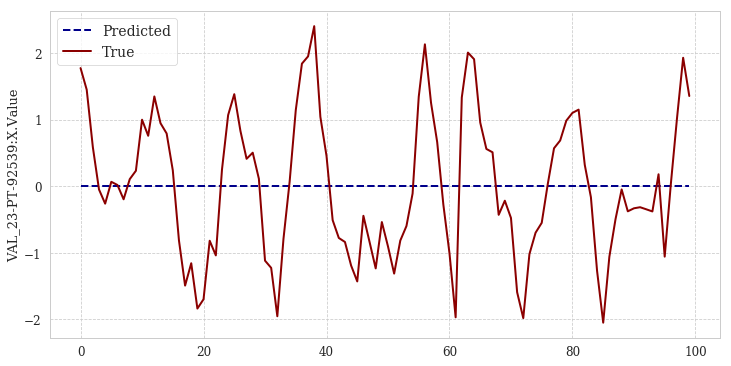

In [156]:
visualise_heuristic(predict_mean, signal=2)

In [157]:
print("\nPREDICTING MEAN")
val_mean, test_mean = evaluate_heuristic(predict_mean, y_valid, y_test)


PREDICTING MEAN

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.85732 |             2894.97454 |
|  1 | VAL_23-TT-92539:X.Value    |              1.38640 |                1.35303 |
|  2 | VAL_23-PT-92539:X.Value    |              0.83291 |                0.20613 |
|  3 | Average                    |              1.02555 |              965.51124 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-

### Predicting the moving average 
---
Initial value of the mean of the trainign data

In [158]:
def predict_ma(y_data):
    cumsum = np.cumsum(y_data, axis=0)
    ma = np.array([cumsum[n-1]/n for n in range(1,len(cumsum)+1)])
    
    preds = ma[:-1]
    targets = y_data[1:]
    return preds, targets

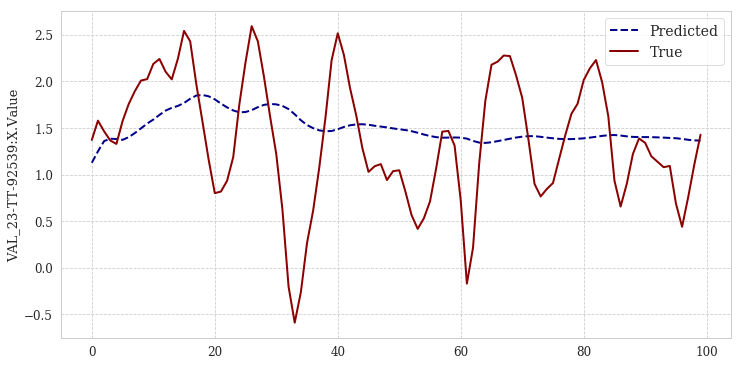

In [159]:
visualise_heuristic(predict_ma)

In [160]:
print("\nPREDICTING MOVING AVERAGE")
val_ma, test_ma = evaluate_heuristic(predict_ma, y_valid, y_test)


PREDICTING MOVING AVERAGE

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.83431 |             2817.25905 |
|  1 | VAL_23-TT-92539:X.Value    |              0.71069 |                0.69358 |
|  2 | VAL_23-PT-92539:X.Value    |              0.83317 |                0.20620 |
|  3 | Average                    |              0.79272 |              939.38627 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0

## TODO: Summary

# Linear Regression
---

In [161]:
def evaluate_linear_model(model, x_valid=x_valid, y_valid=y_valid, x_test=x_test, y_test=y_test):
    """
    Prints the performance of a model on the validation and testing data. Returns dictionaries of the validation
    and testing error. 
    
    :param model: The fitted model that can use the .predict() function
    :param x_valid: matrix of validation features. Default=x_valid.
    :param y_valid: matrix of validation targets. Default=y_valid.
    :param x_test: matrix of test features. Default=x_test.
    :param y_test: matrix of test targets. Default=y_test. 
    
    :return: dictionaries of validation and test errors as returned from evaluate_error()
    """
    
    print("\n       Validation data")
    preds = model.predict(x_valid)
    targets = y_valid
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds = model.predict(x_test)
    targets = y_test
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [184]:
def plot_linear_model(model, x_data=x_valid, y_data=y_valid, start_idx=0, n_obs=200, signal=1):
    """
    Plots a sample of the linear model.
    """
    preds = model.predict(x_data)
    targets = y_data
    
    plt.figure()
    plt.plot(preds[start_idx:start_idx+n_obs,signal], color="darkblue", lw=2, label="Predictions")
    plt.plot(targets[start_idx:start_idx+n_obs,signal], color="darkred", lw=2, label="True")
    plt.legend(frameon=True)
    plt.ylabel(target_tags[signal])
    
    plt.show()

In [ ]:
lm = LinearRegression()
lm.fit(x_train)

In [218]:
feature_tags[:10]

array(['VAL_23-FT-92537-01:X.Value', 'VAL_23-TT-92539:X.Value',
       'VAL_23-PT-92539:X.Value', 'VAL_23-FT-92512:X.Value',
       'VAL_23-FT-92521:X.Value', 'VAL_23-FT-96151:X.Value',
       'VAL_23-FT-96152:X.Value', 'VAL_23-FT-96158:X.Value',
       'VAL_23-FT-96159:X.Value', 'VAL_23-KA-9101-M01-62B:X.Value'],
      dtype=object)

In [229]:
look_at=13
feature_tags[10-1]

'VAL_23-KA-9101-M01-62B:X.Value'

['VAL_23-FT-92537-01:X.Value' 'VAL_23-TT-92539:X.Value'
 'VAL_23-PT-92539:X.Value' 'VAL_23-FT-92512:X.Value'
 'VAL_23-FT-92521:X.Value' 'VAL_23-FT-96151:X.Value'
 'VAL_23-FT-96152:X.Value' 'VAL_23-FT-96158:X.Value'
 'VAL_23-FT-96159:X.Value' 'VAL_23-KA-9101-M01-62B:X.Value'
 'VAL_23-KA-9101_APE:VALUE' 'VAL_23-KA-9101_APH:VALUE'
 'VAL_23-KA-9101_APR:VALUE' 'VAL_23-KA-9101_ASP:VALUE'
 'VAL_23-KA-9101_EPE:VALUE' 'VAL_23-KA-9101_EPH:VALUE'
 'VAL_23-KA-9101_EPR:VALUE' 'VAL_23-KA-9101_ESP:VALUE'
 'VAL_23-KA-9101_PHD:VALUE' 'VAL_23-KA-9101_PRD:VALUE'
 'VAL_23-KA-9101_SPD:VALUE' 'VAL_23-LIC-92521:Z.X.Value'
 'VAL_23-LIC-92521:Z.Y.Value' 'VAL_23-LT-92523:Z.X1.Value'
 'VAL_23-LT-92523:Z.X2.Value' 'VAL_23-LT-96182-03:X.Value'
 'VAL_23-LT-96182:Z.X1.Value' 'VAL_23-LT-96182:Z.X2.Value'
 'VAL_23-PDI-96149:X.Value' 'VAL_23-PDI-96150:X.Value'
 'VAL_23-PDI-96249:X.Value' 'VAL_23-PDT-92502:X.Value'
 'VAL_23-PDT-92522:X.Value' 'VAL_23-PDT-92530:X.Value'
 'VAL_23-PDT-92534:X.Value' 'VAL_23-PDT-92602:X.Val

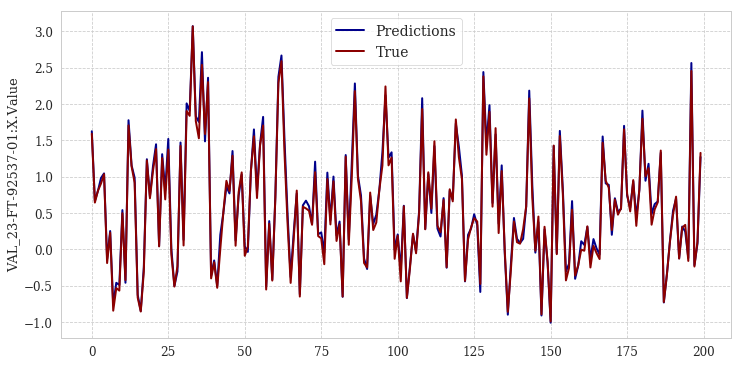

In [233]:
from sklearn.linear_model import LinearRegression
# using the standard settings https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

lm = LinearRegression()
n_features = 50
print(feature_tags[:n_features])
lm.fit(x_train[:,:n_features], y_train)
pred = lm.predict(x_valid[:,:n_features])

plot_linear_model(lm, x_valid[:,:n_features], y_valid, signal=0)



In [169]:
print("\n LINEAR REGRESSION MODEL")
val_linear, test_linear = evaluate_linear_model(lm, x_valid, y_valid, x_test, y_test)


 LINEAR REGRESSION MODEL

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.07055 |              238.21539 |
|  1 | VAL_23-TT-92539:X.Value    |              0.14689 |                0.14335 |
|  2 | VAL_23-PT-92539:X.Value    |              0.00833 |                0.00206 |
|  3 | Average                    |              0.07526 |               79.45360 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 

In [235]:

from cognite.client import CogniteClient
client = CogniteClient(api_key=os.environ['COGNITE_API_SECRET'])

scrubber_file_name = 'PH-ME-P-0153-001'
client.files.list_files(name=scrubber_file_name).to_pandas()

client.files.download_file(client.files.list_files(name=scrubber_file_name).to_pandas().id[0])

'https://storage.googleapis.com/cognite-storage/5977964818434649/7888771415910453/PH-ME-P-0153-001?GoogleAccessId=api-service-account@cognitedata-europe-west1-1.iam.gserviceaccount.com&Expires=1556540067&Signature=nsmSpIoS2va1ftaCrdFi4ds91EGRR4WPOzQ8ty3YL%2BHyJ%2FRdfw1QiBJ9cvWAJVO2V3L%2BiSeF%2FFsluMxLI1LrevRuCZdIRjGELeOGZyl%2FcMRPrvcFo8X2JJnjYP6TAzkfayCr88Mc6uV4C56OQYBq8VHTt9dKDkkNlXjSav%2F3jOh2lTGurUzBCbH46DGRn%2F3ZxAXmcOChez9r34hDjskZqqvhWiCtte1sRXUkVDK5%2FTsCbM%2FnoybXVqbuu87Y%2FDMZyWBVLvdfpMvdiRcU0xXo%2Bchou9XxnnPERT07VZ%2Fzd7046YuPdsMkANjqhhpP0U4qPkXn7Uiv8xA9B0nm36C4pg%3D%3D'